In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [ ]:
df_clean = pd.read_csv('https://raw.githubusercontent.com/fadhlyal/data-set/main/data_clean.csv')

df_new = df_clean

chan_dict = {}
view_dict = {}
chan_arr = []
cat_arr = []
view_arr = []
index = 0

for i in range(df_new.shape[0]) :
  temp_chan = df_new['chanName'].iloc[i]
  temp_cat = df_new['category'].iloc[i]
  temp_view = df_new['viewCount'].iloc[i]
  cat_arr.append(temp_cat)
  if temp_chan in chan_dict :
    chan_arr.append(chan_dict[temp_chan])
    view_input0 = (view_dict[chan_dict[temp_chan]])[0]
    view_input1 = (view_dict[chan_dict[temp_chan]])[1]
    if view_input1 < temp_view :
      if view_input0 > temp_view :
        view_dict[chan_dict[temp_chan]] = [view_input1, temp_view]
      else :
        view_dict[chan_dict[temp_chan]] = [view_input0, temp_view]
    elif view_input0 > temp_view :
      view_dict[chan_dict[temp_chan]] = [temp_view, view_input1]
  else :
    chan_dict[temp_chan] = index
    view_dict[chan_dict[temp_chan]] = [temp_view, temp_view]
    chan_arr.append(chan_dict[temp_chan])
    index += 1

for i in range(df_new.shape[0]) :
  temp_view = df_new['viewCount'].iloc[i]
  index = chan_dict[df_new['chanName'].iloc[i]]

  min = (view_dict[index])[0]
  max = (view_dict[index])[1]

  normal = (temp_view - min) / (max - min)

  if (max-min) == 0 :
    view_arr.append(1.)
  else :
    view_arr.append(normal)

df_new['chan_new'] = chan_arr
df_new['cat_new'] = cat_arr
df_new['view_new'] = view_arr

df_new.head()

<ipython-input-2-85b74fbf1ff8>:41: RuntimeWarning: invalid value encountered in long_scalars
  normal = (temp_view - min) / (max - min)


,vidId,vidTitle,vidUrl,viewCount,likeCount,chanName,chanUrl,subsCount,vidCount,category,chan_new,cat_new,view_new
0,_ymdrlT7KGk,Transformers: Rise Of The Beasts - Di Bioskop ...,https://www.youtube.com/watch?v=_ymdrlT7KGk,1106671,31,UIP Movies Indonesia,https://www.youtube.com/channel/UC5-keBwD6V0qb...,82700,945,1,0,1,0.0
1,EPlsT0X7qnQ,FAST X | Di Bioskop 17 Mei,https://www.youtube.com/watch?v=EPlsT0X7qnQ,5225172,77,UIP Movies Indonesia,https://www.youtube.com/channel/UC5-keBwD6V0qb...,82700,945,1,0,1,1.0
2,qaaJuQlLEyY,Pourquoi on aime les produits de marque Netto ...,https://www.youtube.com/watch?v=qaaJuQlLEyY,3300787,8,NettoFrance,https://www.youtube.com/channel/UCVetyDDXsL0Ne...,2000,114,1,1,1,1.0
3,kJ6BJdVR7s0,The Luminous Solution | Official Teaser 2 | In...,https://www.youtube.com/watch?v=kJ6BJdVR7s0,7747,293,GagaOOLala - Find YourStory,https://www.youtube.com/channel/UCAv7YCgnRo86h...,409000,2335,1,2,1,1.0
4,crt0jGDZpUg,GaviNatura - 100% Natural and Effective Heartb...,https://www.youtube.com/watch?v=crt0jGDZpUg,322383,4,Gaviscon UK,https://www.youtube.com/channel/UC9YXy3ch5DKds...,6500,47,1,3,1,1.0


In [ ]:
td = df_new[["chan_new","cat_new", "view_new"]]
td.head()

,chan_new,cat_new,view_new
0,0,1,0.0
1,0,1,1.0
2,1,1,1.0
3,2,1,1.0
4,3,1,1.0


In [ ]:
df_new["category"].unique()

array([ 1,  2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 34, 35, 37, 44])

In [ ]:
td.chan_new.max()

948

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(td, test_size=0.2, random_state=42)

In [ ]:
train.isnull().sum()

chan_new    0
cat_new     0
view_new    0
dtype: int64

In [ ]:
n_cat = td.cat_new.nunique()
n_channel = td.chan_new.nunique()
# creating book embedding path
cat_input = Input(shape=[1], name="Cat-Input")
cat_embedding = Embedding(input_dim=50, output_dim=5, name="Cat-Embedding")(cat_input)
cat_vec = Flatten(name="Flatten-Cat")(cat_embedding)

# creating user embedding path
channel_input = Input(shape=[1], name="Channel-Input")
channel_embedding = Embedding(n_channel+1, 5, name="Channel-Embedding")(channel_input)
channel_vec = Flatten(name="Flatten-Users")(channel_embedding)

# concatenate features
conc = Concatenate()([cat_vec, channel_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)



In [ ]:
# Create model and compile it
model = Model([channel_input, cat_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Cat-Input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Channel-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Cat-Embedding (Embedding)      (None, 1, 5)         250         ['Cat-Input[0][0]']              
                                                                                                  
 Channel-Embedding (Embedding)  (None, 1, 5)         4750        ['Channel-Input[0][0]']          
                                                                                            

In [ ]:
history = model.fit([train.chan_new, train.cat_new], train.view_new, epochs=100, verbose=1, validation_data=([test.chan_new, test.cat_new], test.view_new))

Epoch 1/100
41/41 [==============================] - 1s 8ms/step - loss: 0.2821 - val_loss: 0.1720
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 0.1694 - val_loss: 0.1530
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.1330 - val_loss: 0.1663
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.1053 - val_loss: 0.1797
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0918 - val_loss: 0.1761
Epoch 6/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0826 - val_loss: 0.1760
Epoch 7/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0787 - val_loss: 0.2045
Epoch 8/100
41/41 [==============================] - 0s 7ms/step - loss: 0.0783 - val_loss: 0.2029
Epoch 9/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0763 - val_loss: 0.2013
Epoch 10/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0747 - val_loss: 0.1965
Epoch 11/

Text(0, 0.5, 'Training Error')

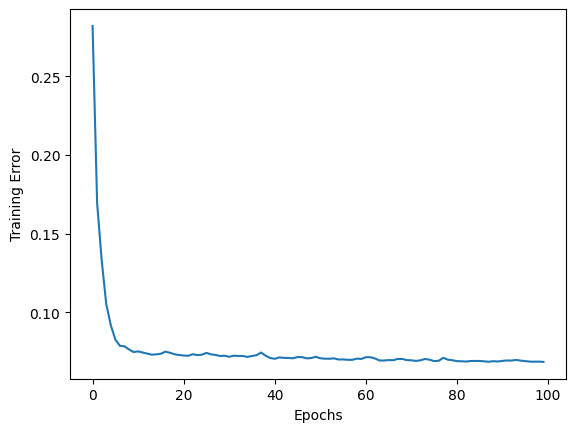

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [ ]:
model.evaluate([test.chan_new, test.cat_new], test.view_new)

11/11 [==============================] - 0s 3ms/step - loss: 0.2421


0.2421211302280426

In [ ]:
model.save('collaborative_filtering.h5')

In [ ]:
# Creating dataset for making recommendations for the first user
category_data = np.array(list(set(td.cat_new)))
category_data[:10]

id_user = 949
user = np.array([id_user for i in range(len(category_data))])
user[:10]

predictions = model.predict([user, category_data])

predictions = np.array([a[0] for a in predictions])

print(predictions)

recommended_category_ids = (-predictions).argsort()[:10]

print(recommended_category_ids)
i=0
recommendation = pd.DataFrame()
while True:
    recommendation = df_clean[df_clean["category"] == recommended_category_ids[i]].sort_values(by=['viewCount'], ascending=False).head()
    if len(recommendation) == 0:
        i =+ 1
    else:
        break
# recommendation = recommendation['vidUrl'].values.tolist()
print(recommendation)

# # print predicted scores
# predictions[recommended_tourism_ids]

1/1 [==============================] - 0s 41ms/step
[0.7690159  0.68739164 0.73442435 0.6831807  0.5997836  0.68133354
 0.7354656  0.6983542  0.70864797 0.63104254 0.68468297 0.6980423
 0.7732725  0.7608242  0.67947096 0.6298048  0.69904673 0.72949207
 0.6383219  0.59661055 0.7831563  0.67750275]
[20 12  0 13  6  2 17  8 16  7]
            vidId                                           vidTitle  \
1335  8dVt7eE3BAo  ☀️ Summer Fun at the Beach ☀️ Talking Angela (...   
1336  UOxkGD8qRB4  K/DA - POP/STARS (ft. Madison Beer, (G)I-DLE, ...   
1337  fB8TyLTD7EE  RISE (ft. The Glitch Mob, Mako, and The Word A...   
1338  r6zIGXun57U  Legends Never Die (ft. Against The Current) | ...   
1339  nwC_BbTrOqA  BEES FIGHT - Alex and Steve Life (Minecraft An...   

                                           vidUrl   viewCount  likeCount  \
1335  https://www.youtube.com/watch?v=8dVt7eE3BAo  1932961395    5373891   
1336  https://www.youtube.com/watch?v=UOxkGD8qRB4   552335292    5922719   
1337  htt